# Importation des packages

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from collections import defaultdict

from tslearn.clustering import TimeSeriesKMeans

f:\py3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Importation du dataset

In [2]:
tseries = pd.read_csv("clients_menages_tabular_transfo.csv")
#tseries.date = pd.to_datetime(tseries.date, format='%Y%m%d')

C:\Users\doanhat\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Les dates enregistrées
dates = ['2018-01-31', '2018-02-28',
 '2018-03-31', '2018-04-30',
 '2018-05-31', '2018-06-30',
 '2018-07-31', '2018-08-31',
 '2018-09-30', '2018-10-31',
 '2018-11-30', '2018-12-31',
 '2019-01-31', '2019-02-28',
 '2019-03-31', '2019-04-30',
 '2019-05-31', '2019-06-30',
 '2019-07-31', '2019-08-31',
 '2019-09-30']
# Nous allons essayer de prédire les soldes. Les variables exogènes ne sont pas prises en compte pour le modèle ARIMA
MA_df = tseries[["id_client", "date", "solde_std"]]

# Prétraitement des données

In [4]:
# Vérifier le pourcentage des lignes vides
len(MA_df[MA_df.isnull().any(axis=1)])/len(MA_df)

0.02018137244571822

In [5]:
MA_df.dropna(axis=0,how='any',inplace=True)

C:\Users\doanhat\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
# Créer une dictionnaire pour stocker pour chaque client les observations lui concernant
MA_df_per_client = {}
for i in MA_df['id_client'].unique():
    df_temp = pd.DataFrame()
    df_temp['solde_std'] = MA_df[MA_df['id_client'] == i]['solde_std']
    df_temp['date'] = MA_df[MA_df['id_client'] == i]['date']
    
    #df_temp['MA_2m'] = df_temp['solde_std'].rolling(window=2).mean()
    #df_temp['MA_3m'] = df_temp['solde_std'].rolling(window=3).mean()
    MA_df_per_client[str(i)] = df_temp

In [7]:
# Fonction permettant de récupérer le MSE d'un modèle ARIMA
from sklearn.model_selection import train_test_split
def getMSE(data:pd.DataFrame,column:str,algorithm:type,kwds:dict,splitSize:float) -> dict:
    size = int(len(data) * splitSize)
    train, test = data.iloc[0:size][column].tolist(), data.iloc[size:len(data)][column].tolist()
    history = [x for x in train]
    predictions = list()
    error = 0
    for t in range(len(test)) :
        model = algorithm(history, **kwds)
        model_fit = model.fit() 
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        error += np.square(yhat - obs)
    return error/len(test)


In [8]:
import json
with open('optimal_parameters_client.json') as json_file:
    arimaParamDict = json.load(json_file)

In [45]:
# Construire un dataframe dont chaque ligne représente un client unique et ses coefficients ARIMA
#AR
errors_AR = []
for clientId,data in MA_df_per_client.items():
    orderArima = arimaParamDict[clientId]
    orderArima = orderArima.split(" ")
    orderArima = tuple([int(i) for i in orderArima])
    try:
        if orderArima[1] == 0 and orderArima[2] == 0 and orderArima[0]:
            errorArima = getMSE(data,'solde_std',ARIMA,{'order':orderArima},0.6) 
        errors_AR.append(errorArima)
    except:
        pass


f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as startin

In [237]:
errors_AR_Series = pd.Series(errors_AR)

In [238]:
errors_AR_Series.where(errors_AR_Series>1000000).isna().value_counts()[0]/len(errors_AR_Series)

0.06947927422923734

In [239]:
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if int(x) == x else '{:.4f}'.format(x)

In [242]:
errors_AR_Series.where(errors_AR_Series<1000000,inplace=True)
errors_AR_Series.describe()

count          6308
mean     64826.7817
std     108735.5154
min         10.8217
25%       8049.0789
50%      34115.8113
75%      80408.0289
max     678238.0402
dtype: float64

In [253]:
errors_AR_Series.where(errors_AR_Series>errors_AR_Series.quantile(0.75)).notna().value_counts()

False    5243
True     1536
dtype: int64

f:\py3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


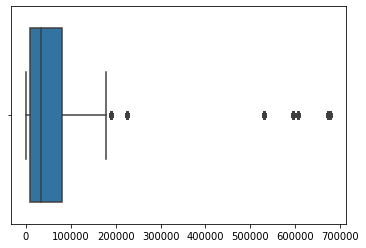

In [245]:
sns.boxplot(errors_AR_Series.where(errors_AR_Series<1000000))

In [70]:
#MA
errors_MA = []
for clientId,data in MA_df_per_client.items():
    orderArima = arimaParamDict[clientId]
    orderArima = orderArima.split(" ")
    orderArima = tuple([int(i) for i in orderArima])
    try:
        if orderArima[0] == 0 and orderArima[1] == 0 and orderArima[2]:
            errorArima = getMSE(data,'solde_std',ARIMA,{'order':orderArima},0.6) 
        errors_MA.append(errorArima)
    except:
        pass


f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceW

In [246]:
errors_MA_Series = pd.Series(errors_MA)

In [247]:
errors_MA_Series.where(errors_MA_Series>1000000).isna().value_counts()[0]/len(errors_MA_Series)

0.016521610857058562

In [248]:
errors_MA_Series.where(errors_MA_Series<1000000,inplace=True)
errors_MA_Series.describe()

count          6667
mean    159097.5209
std     209041.8395
min        170.2034
25%      32627.2418
50%      75824.8054
75%     166631.1651
max     916180.4854
dtype: float64

In [252]:
errors_MA_Series.where(errors_MA_Series>errors_MA_Series.quantile(0.75)).notna().value_counts()

False    5212
True     1567
dtype: int64

f:\py3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


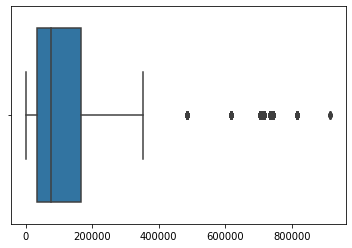

In [251]:
sns.boxplot(errors_MA_Series.where(errors_MA_Series<1000000))

In [82]:
#ARMA
errors_ARMA = []
for clientId,data in MA_df_per_client.items():
    orderArima = arimaParamDict[clientId]
    orderArima = orderArima.split(" ")
    orderArima = tuple([int(i) for i in orderArima])
    try:
        if orderArima[0] and orderArima[1] == 0 and orderArima[2]:
            errorArima = getMSE(data,'solde_std',ARIMA,{'order':orderArima},0.6) 
        errors_ARMA.append(errorArima)
    except:
        pass

f:\py3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\py3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model

In [83]:
errors_ARMA_Series = pd.Series(errors_ARMA)

In [84]:
errors_ARMA_Series.where(errors_ARMA_Series>1000000).isna().value_counts()[0]/len(errors_ARMA_Series)

0.020356984806018587

In [255]:
errors_ARMA_Series.where(errors_ARMA_Series<1000000,inplace=True)
errors_ARMA_Series.describe()

count          6641
mean     62796.6981
std     131729.8413
min          0.6586
25%       1119.5008
50%       9095.5376
75%      29333.0435
max     839329.0729
dtype: float64

In [256]:
errors_ARMA_Series.where(errors_ARMA_Series>errors_ARMA_Series.quantile(0.75)).notna().value_counts()

False    5147
True     1632
dtype: int64

f:\py3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


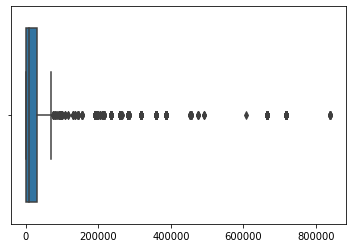

In [85]:
sns.boxplot(errors_ARMA_Series.where(errors_ARMA_Series<1000000))

In [86]:
#ARIMA
errors_ARIMA = []
for clientId,data in MA_df_per_client.items():
    orderArima = arimaParamDict[clientId]
    orderArima = orderArima.split(" ")
    orderArima = tuple([int(i) for i in orderArima])
    try:
        if orderArima[0] and orderArima[1] and orderArima[2]:
            errorArima = getMSE(data,'solde_std',ARIMA,{'order':orderArima},0.6) 
        errors_ARIMA.append(errorArima)
    except:
        pass

f:\py3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\py3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model

f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
f:\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceW

In [87]:
errors_ARIMA_Series = pd.Series(errors_ARIMA)

In [95]:
errors_ARIMA_Series.where(errors_ARIMA_Series>1000000).isna().value_counts()[0]/len(errors_ARIMA_Series)

0.09381914736686826

In [257]:
errors_ARIMA_Series.where(errors_ARIMA_Series<1000000,inplace=True)
errors_ARIMA_Series.describe()

count          6143
mean    126811.2731
std     204986.0065
min          1.9041
25%      16950.4388
50%      50893.1832
75%     120521.1839
max     920194.8770
dtype: float64

In [258]:
errors_ARIMA_Series.where(errors_ARIMA_Series>errors_ARIMA_Series.quantile(0.75)).notna().value_counts()

False    5342
True     1437
dtype: int64

f:\py3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


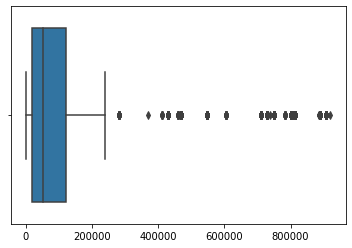

In [96]:
sns.boxplot(errors_ARIMA_Series.where(errors_ARIMA_Series<1000000))

In [101]:
t = np.arange(0.0, 2.0, 0.01)
s1 = np.sin(2*np.pi*t)
s2 = np.sin(4*np.pi*t)

f:\py3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
f:\py3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
f:\py3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
f:\py3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following va

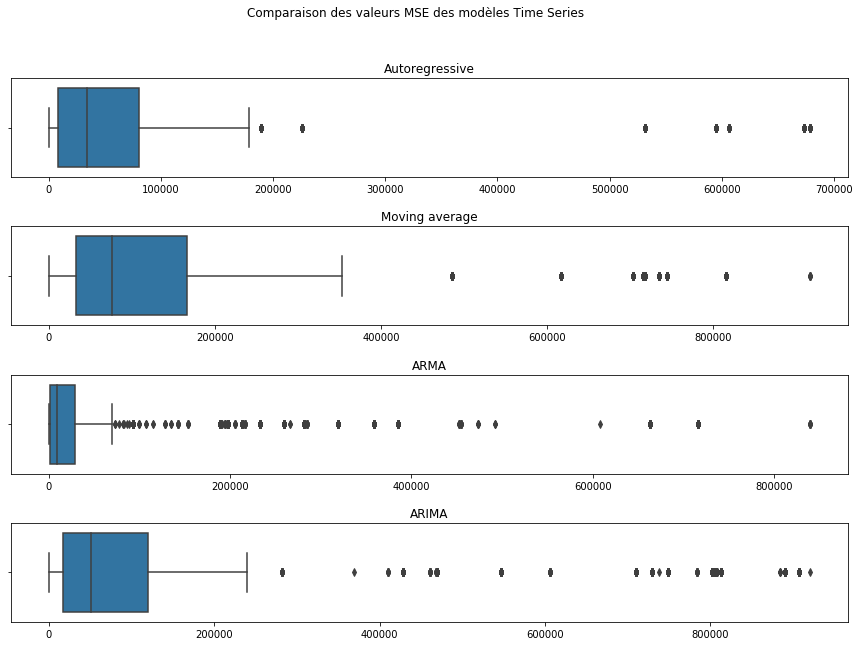

In [196]:
fig, axs = plt.subplots(nrows=4,figsize=(15,10),)
fig.suptitle("Comparaison des valeurs MSE des modèles Time Series")
plt.subplots_adjust(hspace = 0.5)
b1 = sns.boxplot(errors_AR_Series.where(errors_AR_Series<1000000),ax=axs[0])
b1.set_title("Autoregressive")
b2 = sns.boxplot(errors_MA_Series.where(errors_MA_Series<1000000),ax=axs[1]).set_title("Moving average")
b3 = sns.boxplot(errors_ARMA_Series.where(errors_ARMA_Series<1000000),ax=axs[2]).set_title("ARMA")
b4 = sns.boxplot(errors_ARIMA_Series.where(errors_ARIMA_Series<1000000),ax=axs[3]).set_title("ARIMA")